Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.


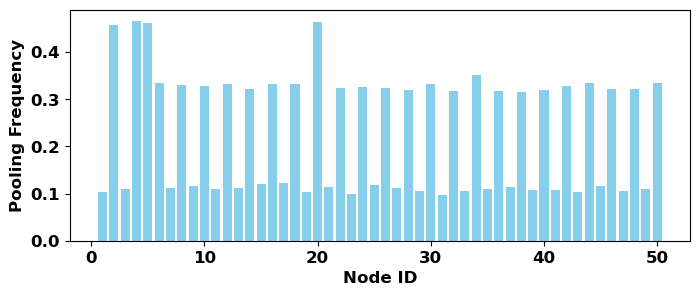

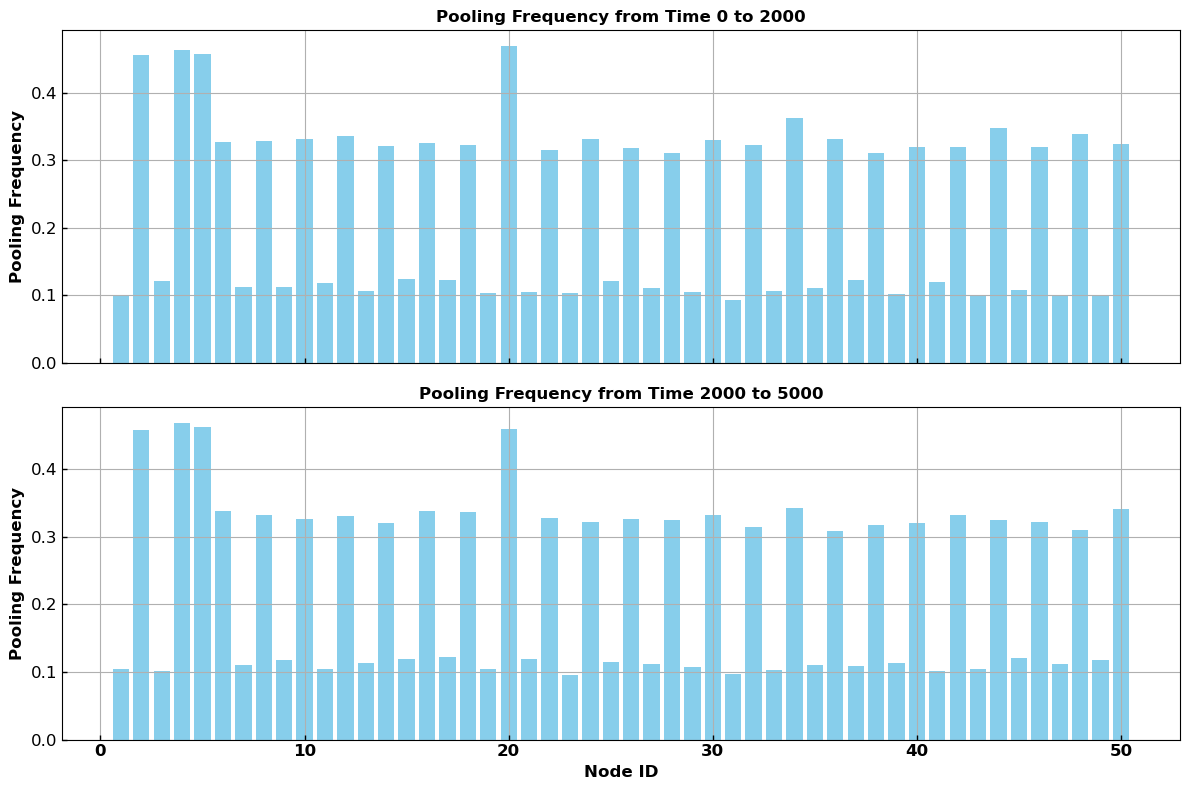

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('simulated_sensor_data.csv')
#pivot_df = pivot_df.head(2000)

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
epsilon = 0.3                         # Sensitivity threshold for event detection
theta = 0.3                           # Threshold for significant change
num_nodes_to_poll_list = [20]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
rho = 1                               # Probability of successful transmission for Whittle index

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# Initialize previous timestamps for delta time calculation
last_update_times = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize tracking arrays
polled_count = {f'mote{i}': 0 for i in range(1, 51)}
transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize state estimates and covariance matrices for Kalman filter
state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}

def calculate_whittle_index(j, rho):
    return j * (j + 1) * rho / 2 + (j + 1)

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def predict_node_state(x_hat, delta_t):
    A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
    return A_delta @ x_hat

def run_simulation(num_nodes_to_poll):
    valuable_sensor_data = []
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    previously_polled_nodes = set()  # Initialize previously_polled_nodes

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        # Check if any node needs to be forcefully pulled due to inactivity
        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        # Calculate the combined metric for each node
        combined_metrics = {}
        for mote in last_update_times:
            j = current_time_step - last_update_times[mote]
            whittle_index = calculate_whittle_index(j, rho)
            delta_t = max(current_time_step - last_update_times[mote], 1)
            predicted_state = predict_node_state(state_estimates[mote], delta_t)
            predicted_value = H @ predicted_state
            current_value = row[mote]
            distance_metric = np.abs(predicted_value - current_value)
            combined_metrics[mote] = whittle_index * distance_metric

        # Select top M nodes based on the combined metric
        nodes_by_combined_metric = sorted(combined_metrics.keys(), key=lambda mote: combined_metrics[mote], reverse=True)
        top_m_nodes = nodes_by_combined_metric[:num_nodes_to_poll]

        # Filter the top M nodes based on the prediction threshold
        nodes_to_poll = list(currently_polled_nodes)
        for mote in top_m_nodes:
            if mote not in previously_polled_nodes:
                delta_t = current_time_step - last_update_times[mote]
                if delta_t > 0:
                    predicted_state = predict_node_state(state_estimates[mote], delta_t)
                    predicted_value = H @ predicted_state
                    current_value = row[mote]
                    if abs(predicted_value - current_value) > theta:
                        nodes_to_poll.append(mote)

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            j = current_time_step - last_update_times[mote]

            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'time_elapsed': j
            })

            # Track the transmission event for the two periods
            if 0 <= current_time_step < 2000:
                transmission_events_1[mote].append(current_time_step)
            elif 2000 <= current_time_step < 5000:
                transmission_events_2[mote].append(current_time_step)

        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    return valuable_sensor_df, transmission_events_1, transmission_events_2

results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    valuable_sensor_df, transmission_events_1, transmission_events_2 = run_simulation(num_nodes_to_poll)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 3))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Node ID', fontsize=12, fontweight='bold')
plt.ylabel('Pooling Frequency', fontsize=12, fontweight='bold')

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.show()

# Plot the transmission frequency over two time periods
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Define the time windows
time_windows = [(0, 2000), (2000, 5000)]

# Plot the transmission frequency for each time window as a ratio
for i, (start, end) in enumerate(time_windows):
    transmission_events = transmission_events_1_list[0] if i == 0 else transmission_events_2_list[0]
    total_time_period = end - start
    transmission_counts = {int(mote.replace('mote', '')): len([t for t in times if start <= t < end]) / total_time_period for mote, times in transmission_events.items()}
    
    axs[i].bar(transmission_counts.keys(), transmission_counts.values(), color='skyblue')
    axs[i].set_ylabel('Pooling Frequency', fontsize=12, fontweight='bold')
    axs[i].set_title(f'Pooling Frequency from Time {start} to {end}', fontsize=12, fontweight='bold')
    axs[i].grid(True)
    axs[i].tick_params(axis='both', which='major', labelsize=12, labelcolor='black', width=1, color='black', direction='in')

axs[-1].set_xlabel('Node ID', fontsize=12, fontweight='bold')

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.


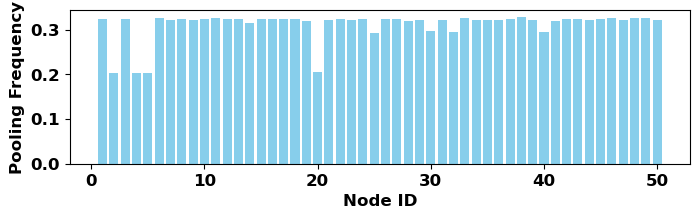

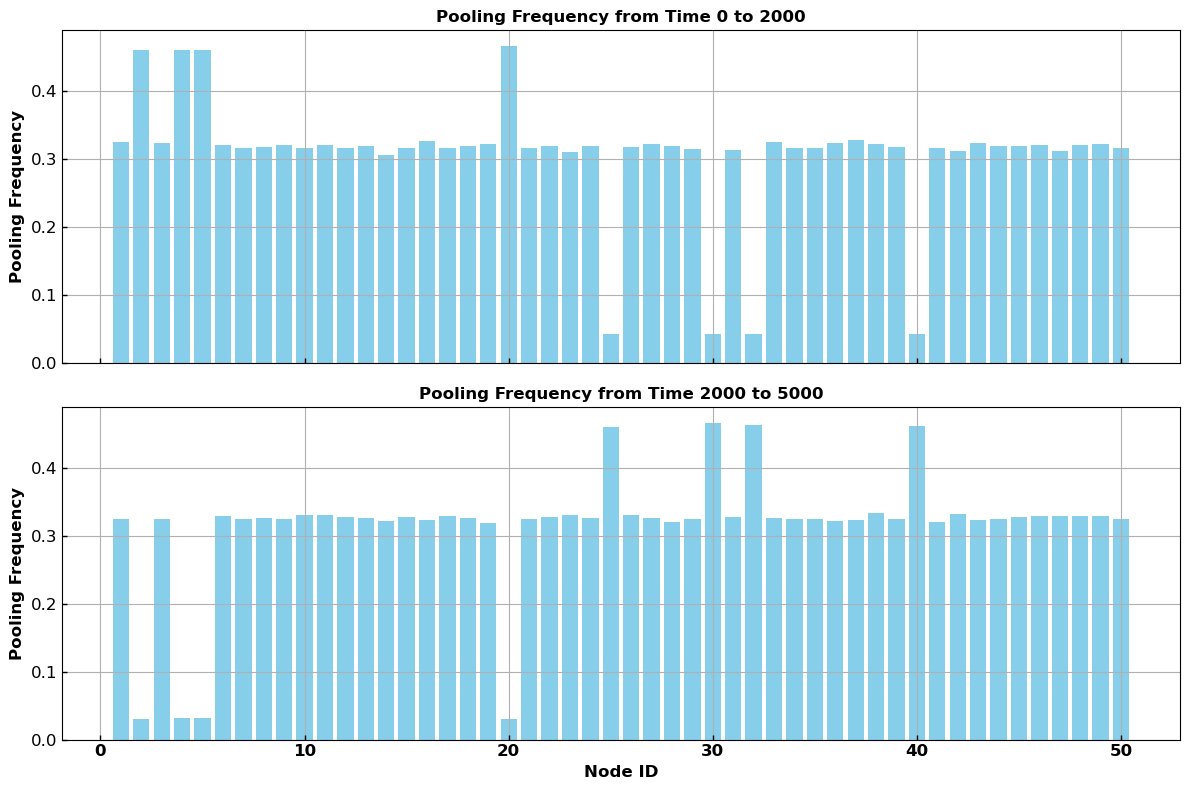

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('synthetic_dataset.csv')
#pivot_df = pivot_df.head(2000)

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
epsilon = 0.3                         # Sensitivity threshold for event detection
theta = 0.3                           # Threshold for significant change
num_nodes_to_poll_list = [20]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
rho = 1                               # Probability of successful transmission for Whittle index

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# Initialize previous timestamps for delta time calculation
last_update_times = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize tracking arrays
polled_count = {f'mote{i}': 0 for i in range(1, 51)}
transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize state estimates and covariance matrices for Kalman filter
state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}

def calculate_whittle_index(j, rho):
    return j * (j + 1) * rho / 2 + (j + 1)

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def predict_node_state(x_hat, delta_t):
    A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
    return A_delta @ x_hat

def run_simulation(num_nodes_to_poll):
    valuable_sensor_data = []
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    previously_polled_nodes = set()  # Initialize previously_polled_nodes

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        # Check if any node needs to be forcefully pulled due to inactivity
        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        # Calculate the combined metric for each node
        combined_metrics = {}
        for mote in last_update_times:
            j = current_time_step - last_update_times[mote]
            whittle_index = calculate_whittle_index(j, rho)
            delta_t = max(current_time_step - last_update_times[mote], 1)
            predicted_state = predict_node_state(state_estimates[mote], delta_t)
            predicted_value = H @ predicted_state
            current_value = row[mote]
            distance_metric = np.abs(predicted_value - current_value)
            combined_metrics[mote] = whittle_index * distance_metric

        # Select top M nodes based on the combined metric
        nodes_by_combined_metric = sorted(combined_metrics.keys(), key=lambda mote: combined_metrics[mote], reverse=True)
        top_m_nodes = nodes_by_combined_metric[:num_nodes_to_poll]

        # Filter the top M nodes based on the prediction threshold
        nodes_to_poll = list(currently_polled_nodes)
        for mote in top_m_nodes:
            if mote not in previously_polled_nodes:
                delta_t = current_time_step - last_update_times[mote]
                if delta_t > 0:
                    predicted_state = predict_node_state(state_estimates[mote], delta_t)
                    predicted_value = H @ predicted_state
                    current_value = row[mote]
                    if abs(predicted_value - current_value) > theta:
                        nodes_to_poll.append(mote)

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            j = current_time_step - last_update_times[mote]

            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'time_elapsed': j
            })

            # Track the transmission event for the two periods
            if 0 <= current_time_step < 2000:
                transmission_events_1[mote].append(current_time_step)
            elif 2000 <= current_time_step < 5000:
                transmission_events_2[mote].append(current_time_step)

        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    return valuable_sensor_df, transmission_events_1, transmission_events_2

results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    valuable_sensor_df, transmission_events_1, transmission_events_2 = run_simulation(num_nodes_to_poll)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Node ID', fontsize=12, fontweight='bold')
plt.ylabel('Pooling Frequency', fontsize=12, fontweight='bold')

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.show()

# Plot the transmission frequency over two time periods
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Define the time windows
time_windows = [(0, 2000), (2000, 5000)]

# Plot the transmission frequency for each time window as a ratio
for i, (start, end) in enumerate(time_windows):
    transmission_events = transmission_events_1_list[0] if i == 0 else transmission_events_2_list[0]
    total_time_period = end - start
    transmission_counts = {int(mote.replace('mote', '')): len([t for t in times if start <= t < end]) / total_time_period for mote, times in transmission_events.items()}
    
    axs[i].bar(transmission_counts.keys(), transmission_counts.values(), color='skyblue')
    axs[i].set_ylabel('Pooling Frequency', fontsize=12, fontweight='bold')
    axs[i].set_title(f'Pooling Frequency from Time {start} to {end}', fontsize=12, fontweight='bold')
    axs[i].grid(True)
    axs[i].tick_params(axis='both', which='major', labelsize=12, labelcolor='black', width=1, color='black', direction='in')

axs[-1].set_xlabel('Node ID', fontsize=12, fontweight='bold')

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()



Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Average sensor lifetime (years): 0.14137724034829202


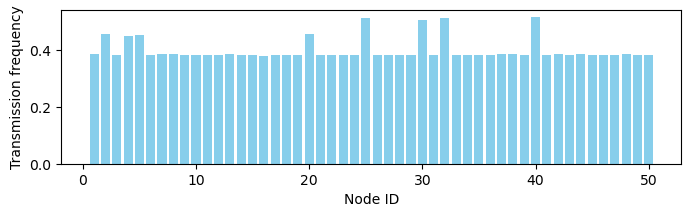

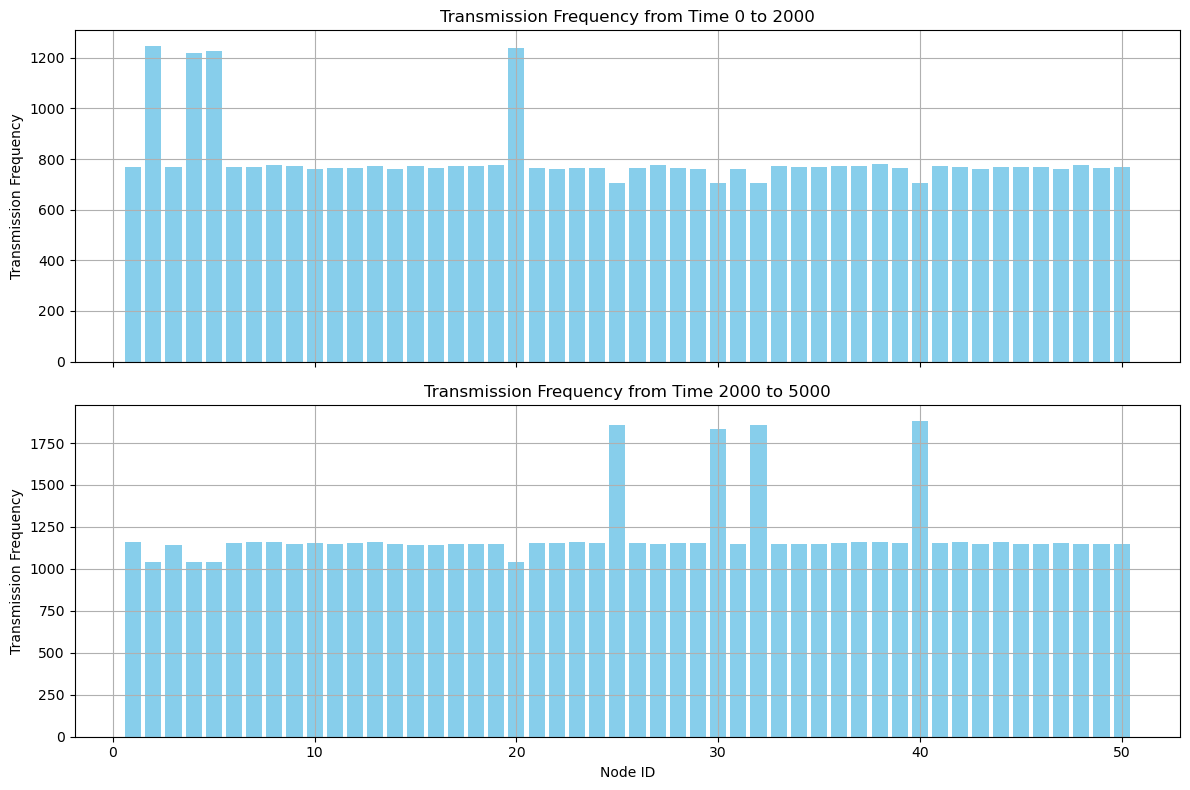

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('synthetic_dataset.csv')
#pivot_df = pivot_df.head(2000)

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
epsilon = 1                        # Sensitivity threshold for event detection
theta = 1                          # Threshold for significant change
num_nodes_to_poll_list = [20]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
rho = 1                             # Probability of successful transmission for Whittle index

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# Initialize previous timestamps for delta time calculation
last_update_times = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize tracking arrays
polled_count = {f'mote{i}': 0 for i in range(1, 51)}
transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize state estimates and covariance matrices for Kalman filter
state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}

def calculate_whittle_index(j, rho):
    return j * (j + 1) * rho / 2 + (j + 1)

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def predict_node_state(x_hat, delta_t):
    A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
    return A_delta @ x_hat

def run_simulation(num_nodes_to_poll):
    valuable_sensor_data = []
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    previously_polled_nodes = set()  # Initialize previously_polled_nodes

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        # Check if any node needs to be forcefully pulled due to inactivity
        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        # Calculate the combined metric for each node
        combined_metrics = {}
        for mote in last_update_times:
            j = current_time_step - last_update_times[mote]
            whittle_index = calculate_whittle_index(j, rho)
            delta_t = max(current_time_step - last_update_times[mote], 1)
            predicted_state = predict_node_state(state_estimates[mote], delta_t)
            predicted_value = H @ predicted_state
            current_value = row[mote]
            distance_metric = np.abs(predicted_value - current_value)
            combined_metrics[mote] = whittle_index + distance_metric

        # Select top M nodes based on the combined metric
        nodes_by_combined_metric = sorted(combined_metrics.keys(), key=lambda mote: combined_metrics[mote], reverse=True)
        top_m_nodes = nodes_by_combined_metric[:num_nodes_to_poll]

        # Include forced pull nodes in the top sensors list
        nodes_to_poll = list(currently_polled_nodes) + top_m_nodes

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            j = current_time_step - last_update_times[mote]

            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'time_elapsed': j
            })

            # Track the transmission event for the two periods
            if 0 <= current_time_step < 2000:
                transmission_events_1[mote].append(current_time_step)
            elif 2000 <= current_time_step < 5000:
                transmission_events_2[mote].append(current_time_step)

        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    return valuable_sensor_df, transmission_events_1, transmission_events_2

results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    valuable_sensor_df, transmission_events_1, transmission_events_2 = run_simulation(num_nodes_to_poll)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Calculate polling and transmission fractions
time_steps = len(pivot_df)
fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

# Calculate the average lifetime of sensors in hours and years
average_lifetime_hours = np.mean([
    E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
]) / 3600

average_lifetime_years = average_lifetime_hours / 8760  # Convert hours to years
print("Average sensor lifetime (years):", average_lifetime_years)

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Node ID')
plt.ylabel('Transmission frequency')

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

plt.show()

# Plot the transmission frequency over two time periods
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Define the time windows
time_windows = [(0, 2000), (2000, 5000)]

# Plot the transmission frequency for each time window
for i, (start, end) in enumerate(time_windows):
    transmission_events = transmission_events_1_list[0] if i == 0 else transmission_events_2_list[0]
    transmission_counts = {int(mote.replace('mote', '')): len([t for t in times if start <= t < end]) for mote, times in transmission_events.items()}
    
    axs[i].bar(transmission_counts.keys(), transmission_counts.values(), color='skyblue')
    axs[i].set_ylabel('Transmission Frequency')
    axs[i].set_title(f'Transmission Frequency from Time {start} to {end}')
    axs[i].grid(True)

axs[-1].set_xlabel('Node ID')

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

plt.tight_layout()
plt.show()


Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Average sensor lifetime (years): 0.16327350686723713
Overall Average MSE: 4.46948304196164


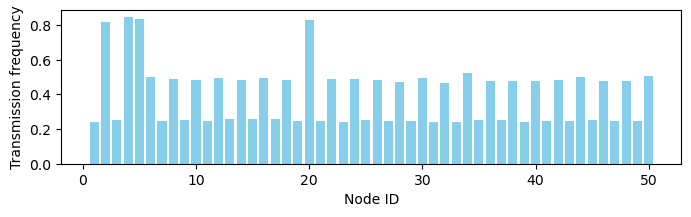

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('simulated_sensor_data.csv')
#pivot_df = pivot_df.head(2000)

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
epsilon = 2                         # Sensitivity threshold for event detection
theta = 2                        # Threshold for significant change
num_nodes_to_poll_list = [20]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
rho = 1                            # Probability of successful transmission for Whittle index

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# Initialize previous timestamps for delta time calculation
last_update_times = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize tracking arrays
polled_count = {f'mote{i}': 0 for i in range(1, 51)}
transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize state estimates and covariance matrices for Kalman filter
state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}

def calculate_whittle_index(j, rho):
    return j * (j + 1) * rho / 2 

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def predict_node_state(x_hat, delta_t):
    A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
    return A_delta @ x_hat

def run_simulation(num_nodes_to_poll):
    valuable_sensor_data = []
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    previously_polled_nodes = set()  # Initialize previously_polled_nodes
    mse_values = {f'mote{i}': [] for i in range(1, 51)}  # To track MSE values for each node

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        # Check if any node needs to be forcefully pulled due to inactivity
        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        # Calculate the combined metric for each node
        combined_metrics = {}
        for mote in last_update_times:
            j = current_time_step - last_update_times[mote]
            whittle_index = calculate_whittle_index(j, rho)
            delta_t = max(current_time_step - last_update_times[mote], 1)
            predicted_state = predict_node_state(state_estimates[mote], delta_t)
            predicted_value = H @ predicted_state
            current_value = row[mote]
            distance_metric = np.abs(predicted_value - current_value)
            combined_metrics[mote] = whittle_index * distance_metric

        # Select top M nodes based on the combined metric
        nodes_by_combined_metric = sorted(combined_metrics.keys(), key=lambda mote: combined_metrics[mote], reverse=True)
        top_m_nodes = nodes_by_combined_metric[:num_nodes_to_poll]

        # Include forced pull nodes in the top sensors list
        nodes_to_poll = list(currently_polled_nodes) + top_m_nodes

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            j = current_time_step - last_update_times[mote]

            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)
            mse_values[mote].append(diff**2)

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'time_elapsed': j
            })

            # Track the transmission event for the two periods
            if 0 <= current_time_step < 1000:
                transmission_events_1[mote].append(current_time_step)
            elif 1000 <= current_time_step < 2000:
                transmission_events_2[mote].append(current_time_step)

        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    # Pad the MSE lists to the same length
    max_length = max(len(v) for v in mse_values.values())
    for key in mse_values:
        mse_values[key].extend([None] * (max_length - len(mse_values[key])))

    mse_df = pd.DataFrame(mse_values)

    return valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df

results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []
mse_df_list = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df = run_simulation(num_nodes_to_poll)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    mse_df_list.append(mse_df)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Calculate polling and transmission fractions
time_steps = len(pivot_df)
fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

# Calculate the average lifetime of sensors in hours and years
average_lifetime_hours = np.mean([
    E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
]) / 3600

average_lifetime_years = average_lifetime_hours / 8760  # Convert hours to years
print("Average sensor lifetime (years):", average_lifetime_years)

# Calculate the overall average MSE
overall_mse = mse_df_list[0].mean().mean()
print(f"Overall Average MSE: {overall_mse}")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Node ID')
plt.ylabel('Transmission frequency')

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

plt.show()




Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Average sensor lifetime (years): 0.18257600452225217
Overall Average MSE: 9.862668764674904


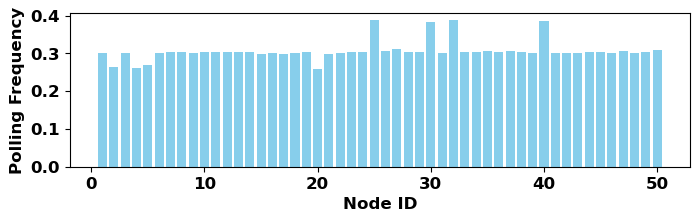

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('synthetic_dataset.csv')
#pivot_df = pivot_df.head(10000)

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
epsilon = 0.5                         # Sensitivity threshold for event detection
theta = 0.5                          # Threshold for significant change
num_nodes_to_poll_list = [20]         # List of numbers of nodes to poll
force_pull_threshold = 200           # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
rho = 1                             # Probability of successful transmission for Whittle index

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# Initialize previous timestamps for delta time calculation
last_update_times = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize tracking arrays
polled_count = {f'mote{i}': 0 for i in range(1, 51)}
transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize state estimates and covariance matrices for Kalman filter
state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}

def calculate_whittle_index(j, rho):
    return j * (j + 1) * rho / 2  

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def predict_node_state(x_hat, delta_t):
    A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
    return A_delta @ x_hat

def run_simulation(num_nodes_to_poll):
    valuable_sensor_data = []
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    previously_polled_nodes = set()  # Initialize previously_polled_nodes
    mse_values = {f'mote{i}': [] for i in range(1, 51)}  # To track MSE values for each node

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        # Check if any node needs to be forcefully pulled due to inactivity
        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        # Calculate the combined metric for each node
        combined_metrics = {}
        for mote in last_update_times:
            j = current_time_step - last_update_times[mote]
            whittle_index = calculate_whittle_index(j, rho)
            delta_t = max(current_time_step - last_update_times[mote], 1)
            predicted_state = predict_node_state(state_estimates[mote], delta_t)
            predicted_value = H @ predicted_state
            current_value = row[mote]
            distance_metric = np.abs(predicted_value - current_value)
            combined_metrics[mote] = whittle_index * distance_metric

        # Select top M nodes based on the combined metric
        nodes_by_combined_metric = sorted(combined_metrics.keys(), key=lambda mote: combined_metrics[mote], reverse=True)
        top_m_nodes = nodes_by_combined_metric[:num_nodes_to_poll]

        # Include forced pull nodes in the top sensors list
        nodes_to_poll = list(currently_polled_nodes) + top_m_nodes

        # Apply the additional check before pulling
        final_nodes_to_poll = []
        for mote in nodes_to_poll:
            delta_t = max(current_time_step - last_update_times[mote], 1)
            predicted_state = predict_node_state(state_estimates[mote], delta_t)
            predicted_value = H @ predicted_state
            current_value = row[mote]
            if abs(predicted_value - current_value) > theta:
                final_nodes_to_poll.append(mote)

        for mote in final_nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            j = current_time_step - last_update_times[mote]

            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)
            mse_values[mote].append(diff**2)

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'time_elapsed': j
            })

            # Track the transmission event for the two periods
            if 0 <= current_time_step < 2000:
                transmission_events_1[mote].append(current_time_step)
            elif 2000 <= current_time_step < 5000:
                transmission_events_2[mote].append(current_time_step)

        previously_polled_nodes = set(final_nodes_to_poll)

        for mote in final_nodes_to_poll:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    # Pad the MSE lists to the same length
    max_length = max(len(v) for v in mse_values.values())
    for key in mse_values:
        mse_values[key].extend([None] * (max_length - len(mse_values[key])))

    mse_df = pd.DataFrame(mse_values)

    return valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df

results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []
mse_df_list = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    valuable_sensor_df, transmission_events_1, transmission_events_2, mse_df = run_simulation(num_nodes_to_poll)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    mse_df_list.append(mse_df)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Calculate polling and transmission fractions
time_steps = len(pivot_df)
fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

# Calculate the average lifetime of sensors in hours and years
average_lifetime_hours = np.mean([
    E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
]) / 3600

average_lifetime_years = average_lifetime_hours / 8760  # Convert hours to years
print("Average sensor lifetime (years):", average_lifetime_years)

# Calculate the overall average MSE
overall_mse = mse_df_list[0].mean().mean()
print(f"Overall Average MSE: {overall_mse}")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Node ID', fontsize=12, fontweight='bold')
plt.ylabel('Polling Frequency', fontsize=12, fontweight='bold')

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.show()


# Pooling comparison 

# Kalman_pooling

Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.


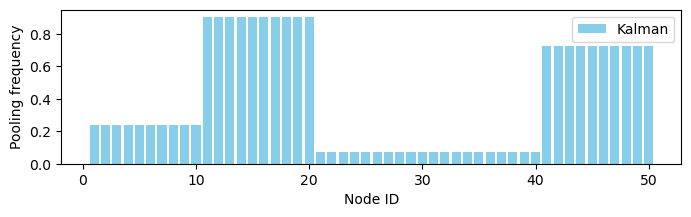

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('simulated_sensor_data.csv')
#pivot_df = pd.read_csv('synthetic_dataset.csv')
#pivot_df = pivot_df.head(10000)

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
epsilon = 0.3                         # Sensitivity threshold for event detection
theta = 2                             # Threshold for significant change
num_nodes_to_poll_list = [20]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}

    def predict_node_state(x_hat, delta_t):
        A = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix
        return A @ x_hat

    def select_top_nodes(state_estimates, P, num_nodes_to_poll, currently_polled_nodes):
        covariance_traces = {mote: np.trace(P[mote]) for mote in state_estimates}
        sorted_motes_by_trace = sorted(covariance_traces, key=covariance_traces.get, reverse=True)
        top_nodes = set(sorted_motes_by_trace[:num_nodes_to_poll])
        return top_nodes | currently_polled_nodes

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        top_sensors = select_top_nodes(state_estimates, P, num_nodes_to_poll, currently_polled_nodes)

        for mote in top_sensors:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            
            A = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix
            xp = A @ previous_state
            Pp = A @ previous_P @ A.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            predicted_measurement = predict_node_state(x_hat, delta_t)[0, 0]
            diff = abs(measured_value - predicted_measurement)
            R_s =  diff
            if np.isnan(R_s):
                R_s = 0  # Replace NaN rewards with zero
                last_sensed_values[mote] = measured_value
                transmitted_count[mote] += 1

            last_update_times[mote] = current_time_step

    return polled_count

results = {}
polled_counts_kalman = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    polled_count = run_simulation(num_nodes_to_poll)
    polled_counts_kalman.append(polled_count)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): polled_count[mote] / total_duration for mote in polled_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue', label='Kalman')
plt.xlabel('Node ID')
plt.ylabel('Pooling frequency')
plt.legend()

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks)
plt.savefig('kalman_pooling_frequency.png')
plt.show()


# Oracle pooling 

Running Oracle simulation for 10 nodes to poll...
Completed Oracle simulation for 10 nodes to poll.


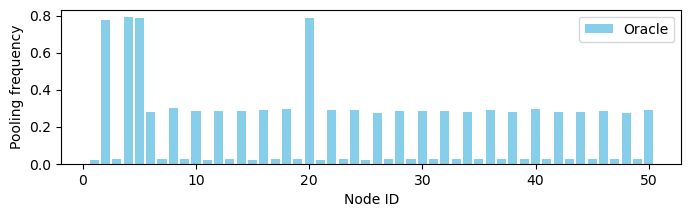

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
#pivot_df = pd.read_csv('synthetic_dataset.csv')
pivot_df = pd.read_csv('simulated_sensor_data.csv')
#pivot_df = pivot_df.head(10000)

# Parameters
num_nodes_to_poll_list = [10]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

def run_oracle_simulation(num_nodes_to_poll):
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}  # Initialize with time step 0
    last_known_values = {f'mote{i}': pivot_df.iloc[0][f'mote{i}'] for i in range(1, 51)}  # Initialize with first row values
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}

    # Start the simulation from the second row (since first row is used for initialization)
    for idx, row in pivot_df.iloc[1:].iterrows():
        current_time_step = idx
        differences = {}

        # Calculate differences between current value and last known value at the sink for all nodes
        for mote in last_update_times:
            current_value = row[mote]
            last_known_value = last_known_values[mote]
            difference = abs(current_value - last_known_value)
            differences[mote] = difference
        
        # Sort nodes by differences and select top M nodes
        top_m_nodes = sorted(differences, key=differences.get, reverse=True)[:num_nodes_to_poll]
        
        for mote in top_m_nodes:
            polled_count[mote] += 1
            last_update_times[mote] = current_time_step
            last_known_values[mote] = row[mote]  # Update the last known value at the sink

    return polled_count

results_oracle = {}
polled_counts_oracle = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running Oracle simulation for {num_nodes_to_poll} nodes to poll...")
    polled_count = run_oracle_simulation(num_nodes_to_poll)
    polled_counts_oracle.append(polled_count)
    print(f"Completed Oracle simulation for {num_nodes_to_poll} nodes to poll.")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): polled_count[mote] / total_duration for mote in polled_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue', label='Oracle')
plt.xlabel('Node ID')
plt.ylabel('Pooling frequency')
plt.legend()

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

# Save the plot
plt.savefig('oracle_pooling_frequency.png')
plt.show()


# Whittle Pooling

Running Whittle simulation for 10 nodes to poll...
Completed Whittle simulation for 10 nodes to poll.


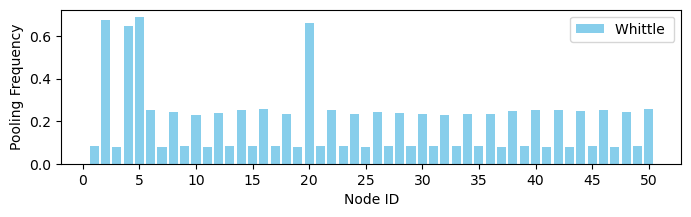

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Load the pivot DataFrame
#pivot_df = pd.read_csv('synthetic_dataset.csv')
pivot_df = pd.read_csv('simulated_sensor_data.csv')
#pivot_df = pivot_df.head(10000)

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
epsilon = 0.3                         # Sensitivity threshold for event detection
theta = 0.5                           # Threshold for significant change (equal to m_i)
num_nodes_to_poll_list = [10]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps
pdr = 0.9                             # Probability of transmission failure

# WhittleArm class
class WhittleArm:
    def __init__(self, initial_value=0.):
        self.value_estimate = initial_value
        
    def update(self, value):
        self.value_estimate = value

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def calculate_q_value(mote, delta_t, predicted_value, current_value):
    """Calculate the Q-value for a given mote."""
    return -theta + (0.1 * delta_t + 0.99 * abs(predicted_value - current_value))

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    whittle_arms = {f'mote{i}': WhittleArm() for i in range(1, 51)}
    transmission_events_1 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1-1000
    transmission_events_2 = {f'mote{i}': [] for i in range(1, 51)}  # To track transmission events for time 1000-2000
    previously_polled_nodes = set()
    cumulative_reward = []

    def predict_node_state(x_hat, delta_t):
        A_delta = get_state_transition_matrix(delta_t)
        return A_delta @ x_hat

    def select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes):
        expected_Q_value = {mote: 0 for mote in state_estimates}
        
        for mote in state_estimates:
            delta_t = current_time_step - last_update_times[mote]
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = last_sensed_values[mote]
                Q_value = calculate_q_value(mote, delta_t, predicted_value, current_value)
                if np.isnan(Q_value):
                    Q_value = 0
                expected_Q_value[mote] = Q_value
        
        for mote in expected_Q_value:
            whittle_arms[mote].update(expected_Q_value[mote])

        # Select top M nodes based on the highest value_estimate in whittle_arms
        nodes_by_whittle = sorted(whittle_arms.keys(), key=lambda mote: whittle_arms[mote].value_estimate, reverse=True)
        top_m_nodes = nodes_by_whittle[:num_nodes_to_poll]

        nodes_to_poll = []
        for mote in top_m_nodes:
            if expected_Q_value[mote] > theta:
                nodes_to_poll.append(mote)
        
        return nodes_to_poll

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll, previously_polled_nodes)
        #nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll

        total_reward_for_round = 0
        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            A_R_s = abs(last_sensed_values[mote] - measured_value)
            if np.isnan(A_R_s):
                A_R_s = 0
            total_reward_for_round += A_R_s

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'Temperature': measured_value,
                'predicted temperature': x_hat[0, 0],
                'time_elapsed': delta_t
            })

            if 0 <= current_time_step < 2000:
                transmission_events_1[mote].append(current_time_step)
            elif 2000 <= current_time_step < 5000:
                transmission_events_2[mote].append(current_time_step)

        cumulative_reward.append(total_reward_for_round)
        previously_polled_nodes = set(nodes_to_poll)

        for mote in nodes_to_poll:
            last_update_times[mote] = current_time_step
            last_sensed_values[mote] = row[mote]

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    valuable_sensor_df['squared_error'] = (valuable_sensor_df['Temperature'] - valuable_sensor_df['predicted temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    return average_mse, cumulative_reward, valuable_sensor_df, transmission_events_1, transmission_events_2, polled_count

# Running the simulation
results = {}
valuable_sensor_df_list = []
transmission_events_1_list = []
transmission_events_2_list = []
cumulative_rewards_whittle = []
polled_counts_list = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running Whittle simulation for {num_nodes_to_poll} nodes to poll...")
    mse, cumulative_reward, valuable_sensor_df, transmission_events_1, transmission_events_2, polled_count = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse}
    cumulative_rewards_whittle.append(cumulative_reward)
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    transmission_events_1_list.append(transmission_events_1)
    transmission_events_2_list.append(transmission_events_2)
    polled_counts_list.append(polled_count)
    print(f"Completed Whittle simulation for {num_nodes_to_poll} nodes to poll.")

# Save cumulative rewards for Whittle to CSV
pd.DataFrame(cumulative_rewards_whittle[0], columns=["cumulative_reward"]).to_csv('cumulative_rewards_whittle.csv', index=False)

# Calculate cumulative reward and cumulative average reward for Whittle
cumulative_reward_array_whittle = np.cumsum(cumulative_rewards_whittle[0])
cumulative_average_reward_whittle = cumulative_reward_array_whittle / (np.arange(len(cumulative_reward_array_whittle)) + 1)

# Plot cumulative average reward over time for Whittle

# Plot the pooling frequency (polling frequency) for each node
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): polled_count[mote] / total_duration for mote in polled_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue', label='Whittle ')
plt.xlabel('Node ID')
plt.ylabel('Pooling Frequency')

plt.xticks(list(range(0, 51, 5)))  # Set x-ticks at intervals of 5
plt.legend()
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('whittle_pooling_frequency.png')  # Save the plot
plt.show()




# UCB Pooling

Running simulation for 10 nodes to poll...
Completed simulation for 10 nodes to poll.


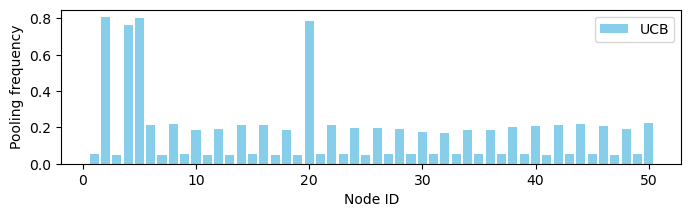

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Load the pivot DataFrame
#pivot_df = pd.read_csv('synthetic_dataset.csv')
pivot_df = pd.read_csv('simulated_sensor_data.csv')
#pivot_df = pivot_df.head(10000)

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
epsilon = 0.3                         # Sensitivity threshold for event detection
theta = 0.5                             # Threshold for significant change (equal to m_i)
num_nodes_to_poll_list = [10]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# UCB parameters
alpha = 2  # Exploration parameter for UCB

# BanditArm class
class BanditArm:
    def __init__(self, initial_value=0.):
        self.value_estimate = initial_value
        self.N = 0  # Number of samples collected so far

    def update(self, value):
        self.N += 1
        self.value_estimate = ((self.N - 1) * self.value_estimate + value) / self.N

def ucb(p_estimate, total_pulls, n):
    return p_estimate + np.sqrt(2 * np.log(total_pulls) / n) if n > 0 else float('inf')

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    bandit_arms = {f'mote{i}': BanditArm() for i in range(1, 51)}

    def predict_node_state(x_hat, delta_t):
        A_delta = get_state_transition_matrix(delta_t)  # Adjust the state transition matrix for the time step
        return A_delta @ x_hat

    def select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll):
        total_pulls = sum(polled_count.values())
        rewards = {mote: 0 for mote in state_estimates}  # Initialize rewards dictionary
        
        for mote in state_estimates:
            delta_t = current_time_step - last_update_times[mote]
            if delta_t > 0:
                predicted_state = predict_node_state(state_estimates[mote], delta_t)
                predicted_value = H @ predicted_state
                current_value = last_sensed_values[mote]
                R_s = -theta + (0.1 * delta_t + 0.99 * abs(predicted_value - current_value))
                if np.isnan(R_s):
                    R_s = 0  # Replace NaN rewards with zero
                rewards[mote] = R_s
        
        # Update value estimates for all nodes
        for mote in rewards:
            bandit_arms[mote].update(rewards[mote])

        ucb_values = {
            mote: ucb(bandit_arms[mote].value_estimate, total_pulls, polled_count[mote])
            for mote in state_estimates
        }
        # Select top M nodes based on UCB scores
        nodes_by_ucb = sorted(ucb_values.keys(), key=lambda mote: ucb_values[mote], reverse=True)
        top_m_nodes = nodes_by_ucb[:num_nodes_to_poll]

        # Filter the top M nodes based on the prediction threshold
        nodes_to_poll = []
        for mote in top_m_nodes:
            if rewards[mote] > theta:
                nodes_to_poll.append(mote)
        
        return nodes_to_poll

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        nodes_to_poll = select_nodes_to_poll(state_estimates, P, last_update_times, last_sensed_values, current_time_step, num_nodes_to_poll)
        #nodes_to_poll = list(currently_polled_nodes) + nodes_to_poll

        for mote in nodes_to_poll:
            polled_count[mote] += 1
            transmitted_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            A_delta = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix

            xp = A_delta @ previous_state
            Pp = A_delta @ previous_P @ A_delta.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            predicted_measurement = predict_node_state(previous_state, delta_t)[0, 0]
            diff = abs(predicted_measurement - measured_value)

            R_s = delta_t * diff  # Calculate the reward
            if np.isnan(R_s):
                R_s = 0  # Replace NaN rewards with zero

            last_update_times[mote] = current_time_step
            last_sensed_values[mote] = row[mote]

    return polled_count

results = {}
polled_counts_ucb = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    polled_count = run_simulation(num_nodes_to_poll)
    polled_counts_ucb.append(polled_count)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): polled_count[mote] / total_duration for mote in polled_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue', label='UCB')
plt.xlabel('Node ID')
plt.ylabel('Pooling frequency')
plt.legend()

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks)
plt.savefig('ucb_pooling_frequency.png')
plt.show()

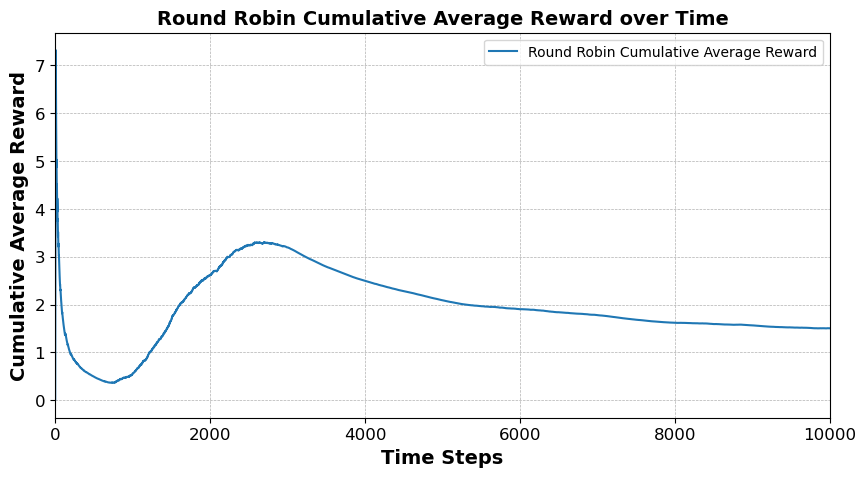

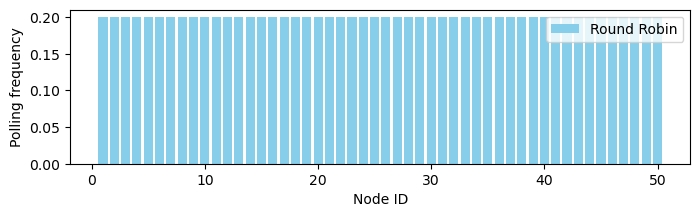

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
pivot_df = pivot_df.head(10000)

# Extract the list of nodes (column names excluding the 'SN' column)
nodes = [col for col in pivot_df.columns if col != 'SN']
total_nodes = len(nodes)  # Total number of nodes
num_pulls_per_round = 10  # Number of nodes to pull in each round
interval = total_nodes // num_pulls_per_round  # Time interval between pulls of the same node
theta = 0.5  # Threshold for significant reward

# Initialize variables
last_measured_values = {node: None for node in nodes}
last_update_times = {node: -interval for node in nodes}
cumulative_reward = []
valuable_sensor_data = []
polled_count = {node: 0 for node in nodes}  # Track polling frequency

def run_round_robin_simulation():
    current_round = 0
    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        node_start = (current_round * num_pulls_per_round) % total_nodes
        nodes_to_poll = nodes[node_start:node_start + num_pulls_per_round]

        total_reward_for_round = 0
        for node in nodes_to_poll:
            measured_value = row[node]
            delta_t = current_time_step - last_update_times[node]

            if last_measured_values[node] is not None:
                R_s = abs(measured_value - last_measured_values[node])
                if R_s > theta:
                    total_reward_for_round += R_s

            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_node': node,
                'temperature': measured_value,
                'time_elapsed': delta_t
            })

            last_update_times[node] = current_time_step
            last_measured_values[node] = measured_value
            polled_count[node] += 1  # Increment polling count

        cumulative_reward.append(total_reward_for_round)
        current_round += 1

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    return cumulative_reward, valuable_sensor_df

# Run the round-robin simulation and collect rewards
round_robin_rewards, valuable_sensor_df = run_round_robin_simulation()

# Save cumulative rewards for round-robin to CSV
pd.DataFrame(round_robin_rewards, columns=["cumulative_reward"]).to_csv('cumulative_rewards_round_robin.csv', index=False)

# Calculate cumulative reward and cumulative average reward for round-robin
cumulative_reward_array = np.cumsum(round_robin_rewards)
cumulative_average_reward = cumulative_reward_array / (np.arange(len(cumulative_reward_array)) + 1)

# Plot cumulative average reward over time
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward)), cumulative_average_reward, label='Round Robin Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=14, fontweight='bold')
plt.title('Round Robin Cumulative Average Reward over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, len(pivot_df))  # Force x-axis to cover the entire length of the dataset

# Save the plot
plt.savefig('round_robin_cumulative_average_reward.png')
plt.show()

# Plot polling frequency
total_duration = len(pivot_df)
ratios = {int(node.replace('mote', '')): polled_count[node] / total_duration for node in polled_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue', label='Round Robin')
plt.xlabel('Node ID')
plt.ylabel('Polling frequency')
plt.legend()

# Set x-ticks at intervals of 10
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

# Save the polling frequency plot
plt.savefig('round_robin_polling_frequency.png')
plt.show()


# Comparison plot 

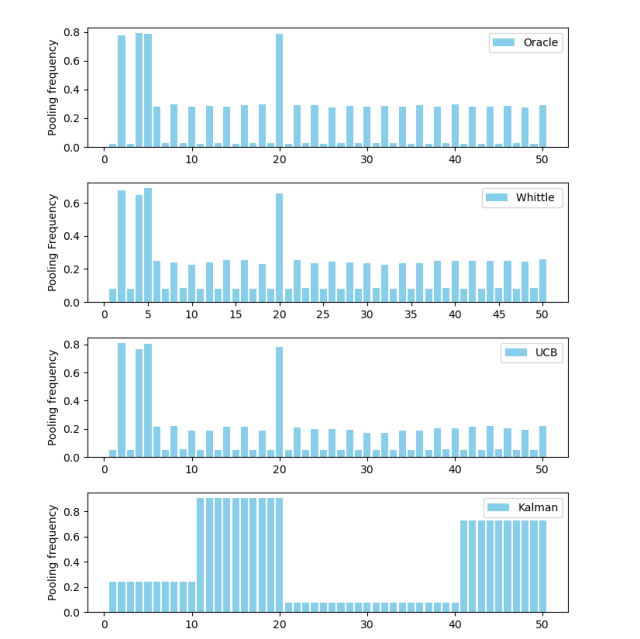

: 

In [63]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

# Load images
oracle_img = Image.open('oracle_pooling_frequency.png')
whittle_img = Image.open('whittle_pooling_frequency.png')
ucb_img = Image.open('ucb_pooling_frequency.png')
kalman_img = Image.open('kalman_pooling_frequency.png')

# Resize images to the same width
width = max(oracle_img.width, whittle_img.width, ucb_img.width, kalman_img.width)

oracle_img = oracle_img.resize((width, int(oracle_img.height * (width / oracle_img.width))))
whittle_img = whittle_img.resize((width, int(whittle_img.height * (width / whittle_img.width))))
ucb_img = ucb_img.resize((width, int(ucb_img.height * (width / ucb_img.width))))

kalman_img = kalman_img.resize((width, int(kalman_img.height * (width / kalman_img.width))))

# Convert images to numpy arrays
oracle_img = np.array(oracle_img)
whittle_img = np.array(whittle_img)
ucb_img = np.array(ucb_img)
kalman_img = np.array(kalman_img)

# Concatenate images vertically
concatenated_img = np.vstack((oracle_img, whittle_img, ucb_img, kalman_img))

# Plot the concatenated image
plt.figure(figsize=(8, 10))
plt.imshow(concatenated_img)
plt.axis('off')  # Hide axes
plt.show()